In [1]:
import os, sys
sys.path.insert(0, os.path.abspath(os.path.join("..", "..")))

# Chicago data

Now with KDE for time and space.

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches
import numpy as np
import sepp.sepp_grid
import sepp.sepp_grid_space
import open_cp.logger
open_cp.logger.log_to_true_stdout("sepp")
open_cp.logger.log_to_true_stdout()
import open_cp.sources.chicago
import open_cp.geometry
import open_cp.evaluation
import descartes
import pickle, lzma, datetime
import open_cp.predictors
#import open_cp.kernels
import scipy.stats
import sepp.kernels

In [3]:
datadir = os.path.join("..", "..", "..", "..", "..", "Data")
#datadir = os.path.join("/media", "disk", "Data")
open_cp.sources.chicago.set_data_directory(datadir)

with lzma.open(os.path.join(datadir, "chicago_all.csv.xz"), "rt") as file:
    all_points = open_cp.sources.chicago.load(file, "BURGLARY", type="all")

In [4]:
northside = open_cp.sources.chicago.get_side("North")
grid = open_cp.data.Grid(150, 150, 0, 0)
grid = open_cp.geometry.mask_grid_by_intersection(northside, grid)

In [5]:
mask = (all_points.timestamps >= np.datetime64("2016-01-01")) & (all_points.timestamps < np.datetime64("2017-01-01"))
points = all_points[mask]
points = open_cp.geometry.intersect_timed_points(points, northside)

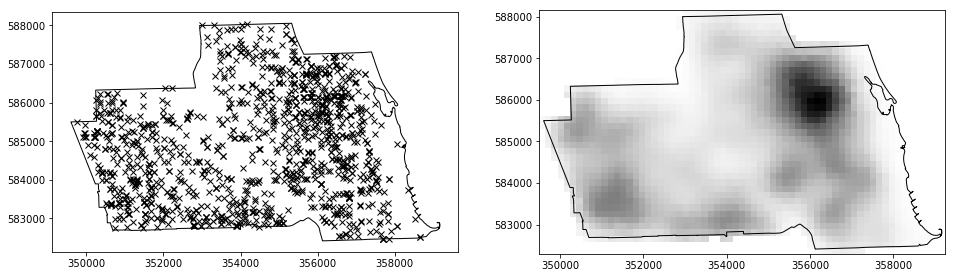

In [6]:
fig, axes = plt.subplots(ncols=2, figsize=(16,10))

ax = axes[0]
ax.add_patch(descartes.PolygonPatch(northside, fc="none"))
ax.set_aspect(1)
ax.scatter(points.xcoords, points.ycoords, marker="x", color="black", linewidth=1)

kernel = open_cp.kernels.GaussianBase(points.coords)
kernel.bandwidth = 300
kernel.covariance_matrix = [[1,0], [0,1]]
pred = open_cp.predictors.grid_prediction_from_kernel_and_masked_grid(kernel, grid, samples=5)
ax = axes[1]
ax.add_patch(descartes.PolygonPatch(northside, fc="none"))
ax.set_aspect(1)
ax.pcolor(*pred.mesh_data(), pred.intensity_matrix, cmap="Greys", rasterized=True)
None

## Some visualisation code

In [7]:
def compute_plot_kde(ker, size):
    x = np.linspace(-size, size, 151)
    y = x
    xcs, ycs = np.meshgrid(x, y)
    z = ker([xcs.flatten(), ycs.flatten()])
    z = z.reshape(xcs.shape)
    return x, y, z

def plot_kde(ax, ker, size, postprocess=None):
    x, y, z = compute_plot_kde(ker, size)
    if postprocess is not None:
        z = postprocess(z)
    return ax.pcolormesh(x,y,z, cmap="Greys", rasterized=True)

def backup_limits(ax):
    xmin, xmax = ax.get_xlim()
    ymin, ymax = ax.get_ylim()
    return xmin, xmax, ymin, ymax

def set_limits(ax, xmin, xmax, ymin, ymax):
    ax.set(xlim=(xmin, xmax), ylim=(ymin, ymax))
    
def plot(model, space_size=35, time_size=100, space_floor=None):
    fig, axes = plt.subplots(ncols=3, figsize=(16,5))

    ax = axes[0]
    ax.add_patch(descartes.PolygonPatch(northside, fc="none"))
    ax.set_aspect(1)
    bpred = open_cp.predictors.GridPredictionArray(grid.xsize, grid.ysize, model.mu, grid.xoffset, grid.yoffset)
    m = ax.pcolor(*bpred.mesh_data(), bpred.intensity_matrix, cmap="Greys", rasterized=True)
    cb = fig.colorbar(m, ax=ax)

    ax = axes[1]
    x = np.linspace(0, time_size, 200)
    y = model.theta * model.time_kernel(x)
    ax.plot(x, y, color="black")
    ax.set(xlabel="Days", ylabel="Trigger risk")
    y = np.max(y)
    for t in range(0, time_size+1):
        ax.plot([t,t],[0,y], color="grey", linewidth=0.5, linestyle="--", zorder=-10)

    pp = None
    if space_floor is not None:
        pp = lambda z : np.log(space_floor + z)
    m = plot_kde(axes[2], model.space_kernel, space_size, pp)
    plt.colorbar(m, ax=axes[2])
        
    fig.tight_layout()
    return fig

def plot_scatter_triggers(backgrounds, trigger_deltas):
    fig, axes = plt.subplots(ncols=3, figsize=(16,5))

    def add_kde(ax, pts):
        xmin, xmax, ymin, ymax = backup_limits(ax)
        x = np.linspace(xmin, xmax, 151)
        y = np.linspace(ymin, ymax, 151)
        xcs, ycs = np.meshgrid(x, y)
        ker = scipy.stats.kde.gaussian_kde(pts)
        z = ker([xcs.flatten(), ycs.flatten()])
        z = z.reshape(xcs.shape)
        z = np.log(np.exp(-15)+z)
        m = ax.pcolorfast(x,y,z, cmap="Greys", rasterized=True, alpha=0.7, zorder=-10)

    ax = axes[0]
    pts = trigger_deltas[1:]
    ax.scatter(*pts, marker="x", color="black", linewidth=1)
    add_kde(ax, pts)
    ax.set_title("Space trigger points")

    ax = axes[1]
    pts = trigger_deltas[[0,1]]
    ax.scatter(*pts, marker="x", color="black", linewidth=1)
    add_kde(ax, pts)
    ax.set(xlabel="days", ylabel="x coord")#, xlim=[0,200])

    ax = axes[2]
    pts = trigger_deltas[[0,2]]
    ax.scatter(*pts, marker="x", color="black", linewidth=1)
    add_kde(ax, pts)
    ax.set(xlabel="days", ylabel="y coord")

    fig.tight_layout()
    return fig

def scatter_triggers(trainer, model, predict_time):
    backgrounds, trigger_deltas = trainer.sample_to_points(model, predict_time)
    return plot_scatter_triggers(backgrounds, trigger_deltas), backgrounds, trigger_deltas

## Fixed bandwidth

In [8]:
tp = sepp.kernels.FixedBandwidthKernelProvider(1)
sp = sepp.kernels.FixedBandwidthKernelProvider(10)
trainer = sepp.sepp_grid_space.Trainer4(grid, tp, sp, p_cutoff=99.99)
trainer.data = points
model = trainer.train(datetime.datetime(2017,1,1), iterations=50)
model

Model4(mu size=(39, 65), T=365.9583333333333, grid=RectangularRegion( (349500,582300) -> (359250,588150) ), theta=0.33639834630591225, time=<open_cp.kernels.Reflect1D object at 0x000001379AFE8DD8>, space=<open_cp.kernels.GaussianBase object at 0x000001379AFE87B8>

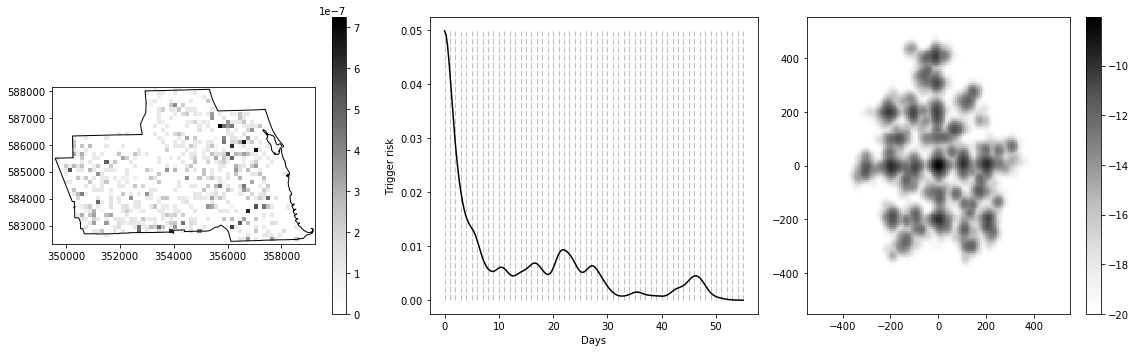

In [9]:
fig = plot(model, space_size=550, time_size=55, space_floor=np.exp(-20))
fig.savefig("../grid_kde_one.pdf")

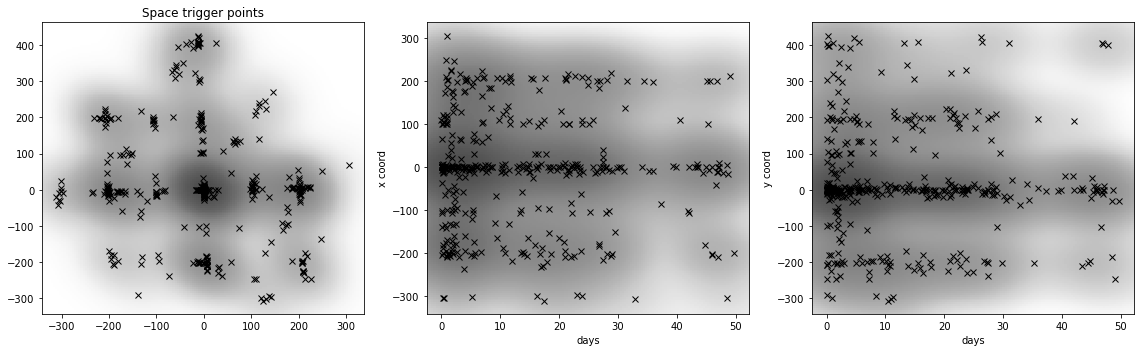

In [12]:
fig, *_ = scatter_triggers(trainer, model, datetime.datetime(2017,1,1))
fig.savefig("../grid_kde_onea.pdf")

In [13]:
T, data = trainer.make_data()
for _ in range(50):
    opt = trainer._optimiser(model, data)
    model = opt.iterate()
model

Model4(mu size=(39, 65), T=365.9583333333333, grid=RectangularRegion( (349500,582300) -> (359250,588150) ), theta=0.4063192411118561, time=<open_cp.kernels.Reflect1D object at 0x000001379E4657F0>, space=<open_cp.kernels.GaussianBase object at 0x000001379E465550>

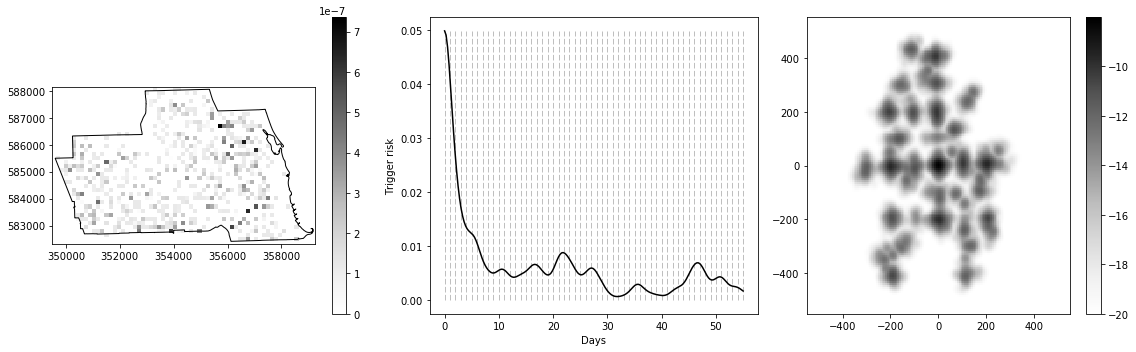

In [14]:
fig = plot(model, space_size=550, time_size=55, space_floor=np.exp(-20))

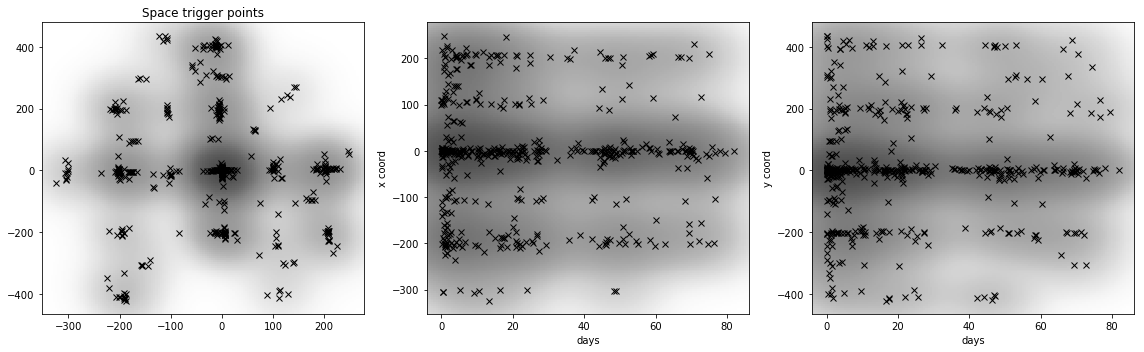

In [15]:
fig, *_ = scatter_triggers(trainer, model, datetime.datetime(2017,1,1))

**With stochastic EM algorithm**

Runs much quicker, but really very different outcome!

In [19]:
tp = sepp.kernels.FixedBandwidthKernelProvider(1)
sp = sepp.kernels.FixedBandwidthKernelProvider(10)
trainer = sepp.sepp_grid_space.Trainer4a(grid, tp, sp, p_cutoff=99.99)
trainer.data = points
model = trainer.train(datetime.datetime(2017,1,1), iterations=150)
model

Model4(mu size=(39, 65), T=365.9583333333333, grid=RectangularRegion( (349500,582300) -> (359250,588150) ), theta=0.12219881255007721, time=<open_cp.kernels.Reflect1D object at 0x000001379D888A58>, space=<open_cp.kernels.GaussianBase object at 0x00000137A5A5A828>

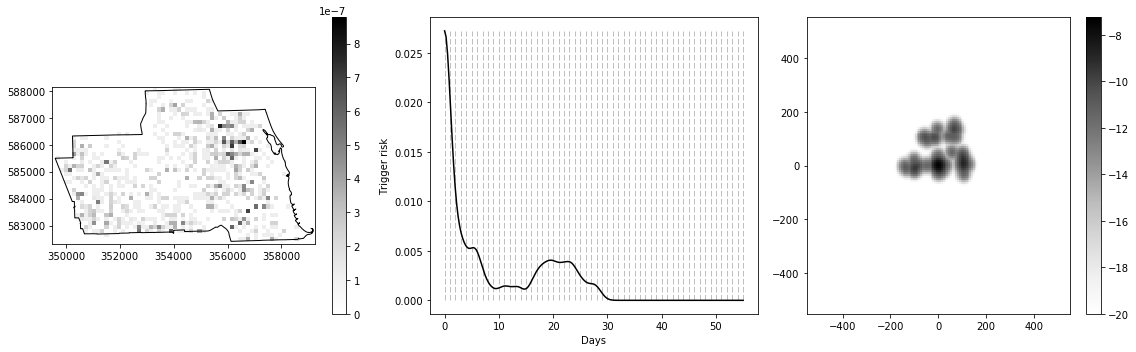

In [20]:
fig = plot(model, 550, 55, np.exp(-20))
fig.savefig("../grid_kde_two.pdf")

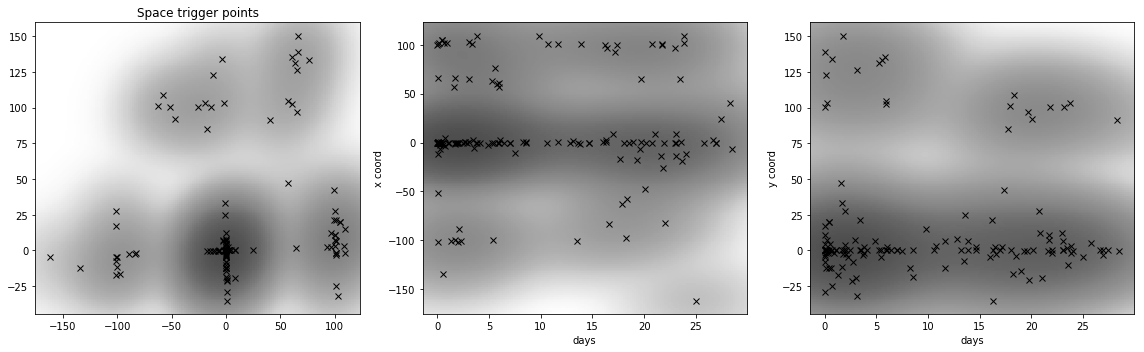

In [21]:
_ = scatter_triggers(trainer, model, datetime.datetime(2017,1,1))

**Slightly larger space bandwidth**

In [31]:
tp = sepp.kernels.FixedBandwidthKernelProvider(1)
sp = sepp.kernels.FixedBandwidthKernelProvider(20)
trainer = sepp.sepp_grid_space.Trainer4(grid, tp, sp)
trainer.data = points
model = trainer.train(datetime.datetime(2017,1,1), iterations=50)
model

Model4(mu size=(39, 65), T=365.9583333333333, grid=RectangularRegion( (349500,582300) -> (359250,588150) ), theta=0.11905055099661971, time=<open_cp.kernels.Reflect1D object at 0x00000137A14CF208>, space=<open_cp.kernels.GaussianBase object at 0x000001379D8045C0>

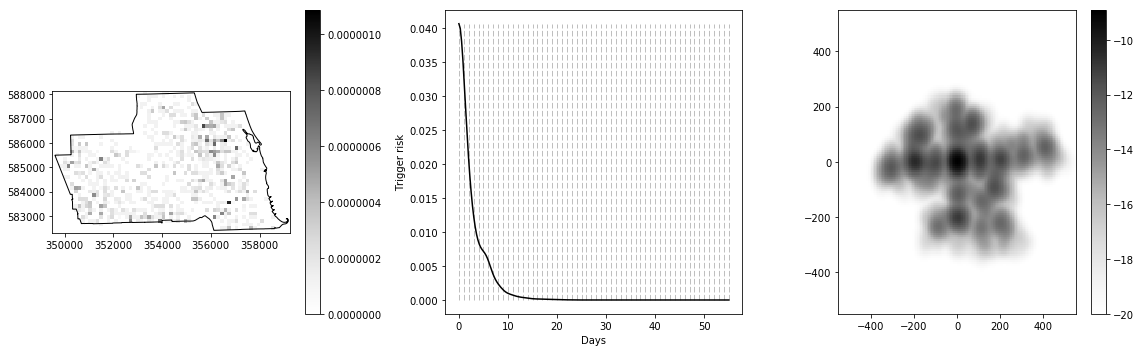

In [32]:
fig = plot(model, 550, 55, np.exp(-20))

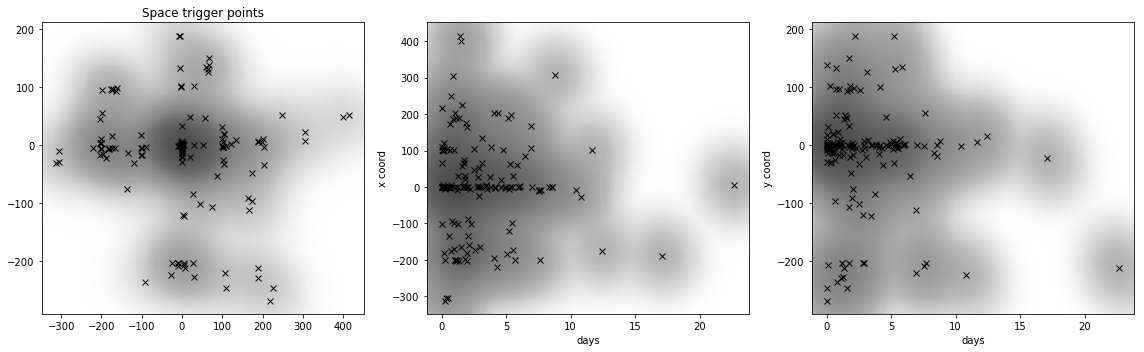

In [33]:
_ = scatter_triggers(trainer, model, datetime.datetime(2017,1,1))

**Somewhat larger space bandwidth**

In [25]:
tp = sepp.kernels.FixedBandwidthKernelProvider(1)
sp = sepp.kernels.FixedBandwidthKernelProvider(50)
trainer = sepp.sepp_grid_space.Trainer4(grid, tp, sp)
trainer.data = points
model = trainer.train(datetime.datetime(2017,1,1), iterations=50)
model

Model4(mu size=(39, 65), T=365.9583333333333, grid=RectangularRegion( (349500,582300) -> (359250,588150) ), theta=0.057760421328701995, time=<open_cp.kernels.Reflect1D object at 0x000001379E708BE0>, space=<open_cp.kernels.GaussianBase object at 0x00000137A574C9B0>

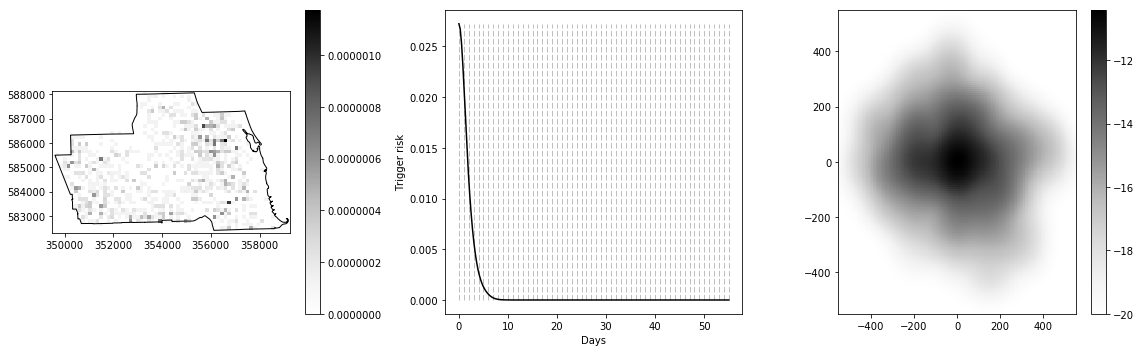

In [26]:
fig = plot(model, 550, 55, np.exp(-20))
fig.savefig("../grid_kde_three.pdf")

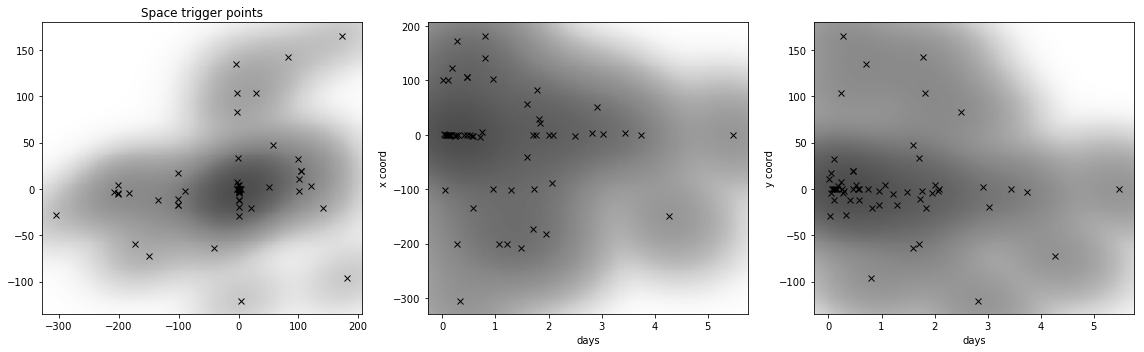

In [27]:
_ = scatter_triggers(trainer, model, datetime.datetime(2017,1,1))

** Same space bandwidth, but much smaller time bandwidth**

In [28]:
tp = sepp.kernels.FixedBandwidthKernelProvider(0.2)
sp = sepp.kernels.FixedBandwidthKernelProvider(50)
trainer = sepp.sepp_grid_space.Trainer4(grid, tp, sp)
trainer.data = points
model = trainer.train(datetime.datetime(2017,1,1), iterations=50)
model

Model4(mu size=(39, 65), T=365.9583333333333, grid=RectangularRegion( (349500,582300) -> (359250,588150) ), theta=0.07311818282641996, time=<open_cp.kernels.Reflect1D object at 0x000001379D803518>, space=<open_cp.kernels.GaussianBase object at 0x00000137A07302B0>

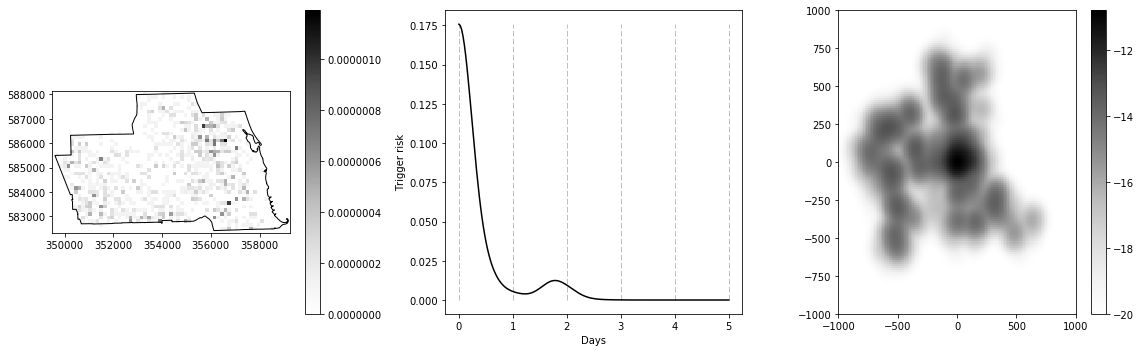

In [29]:
fig = plot(model, 1000, 5, np.exp(-20))

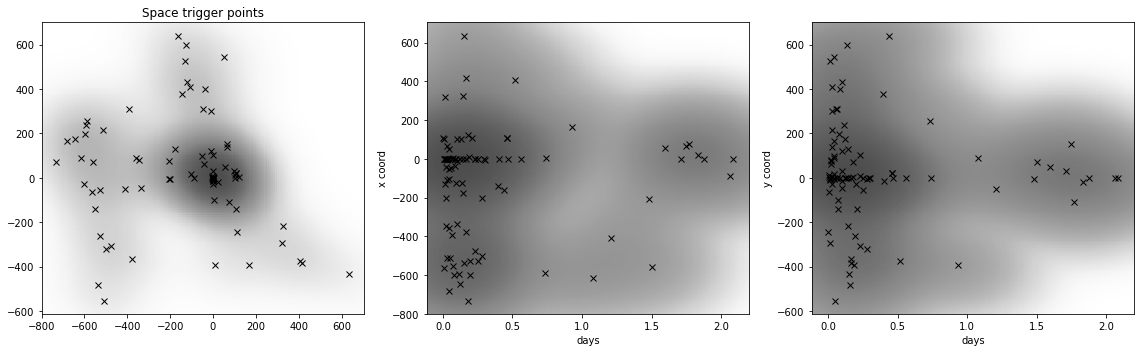

In [30]:
_ = scatter_triggers(trainer, model, datetime.datetime(2017,1,1))

**Now start shrinking the space bandwidth back**

In [34]:
tp = sepp.kernels.FixedBandwidthKernelProvider(0.2)
sp = sepp.kernels.FixedBandwidthKernelProvider(20)
trainer = sepp.sepp_grid_space.Trainer4(grid, tp, sp)
trainer.data = points
model = trainer.train(datetime.datetime(2017,1,1), iterations=50)
model

Model4(mu size=(39, 65), T=365.9583333333333, grid=RectangularRegion( (349500,582300) -> (359250,588150) ), theta=0.12666151534635783, time=<open_cp.kernels.Reflect1D object at 0x000001379DE10978>, space=<open_cp.kernels.GaussianBase object at 0x000001379D9C3BE0>

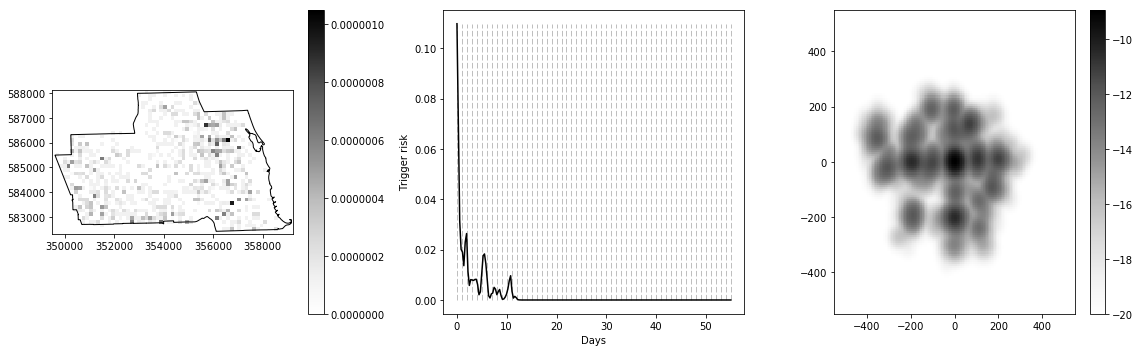

In [35]:
fig = plot(model, 550, 55, np.exp(-20))

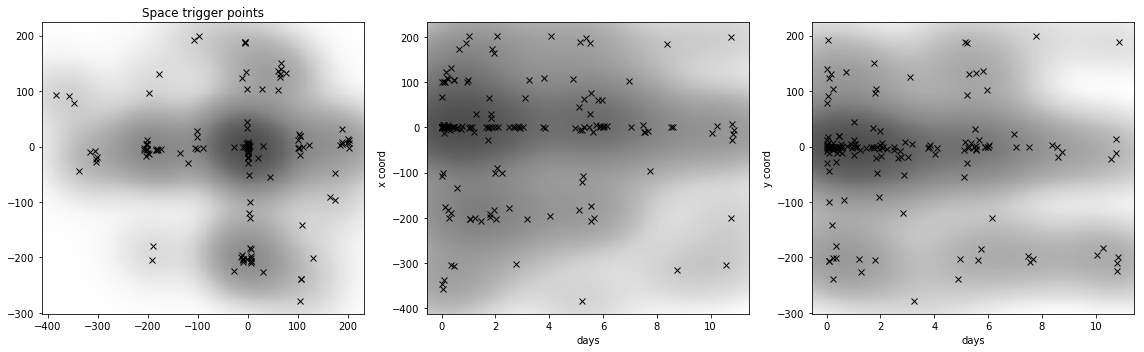

In [36]:
_ = scatter_triggers(trainer, model, datetime.datetime(2017,1,1))

**And with a very small space bandwidth**

In [37]:
tp = sepp.kernels.FixedBandwidthKernelProvider(0.2)
sp = sepp.kernels.FixedBandwidthKernelProvider(2)
trainer = sepp.sepp_grid_space.Trainer4(grid, tp, sp)
trainer.data = points
model = trainer.train(datetime.datetime(2017,1,1), iterations=50)
model

Model4(mu size=(39, 65), T=365.9583333333333, grid=RectangularRegion( (349500,582300) -> (359250,588150) ), theta=0.27538290087144246, time=<open_cp.kernels.Reflect1D object at 0x000001379D938DA0>, space=<open_cp.kernels.GaussianBase object at 0x000001379D8E7320>

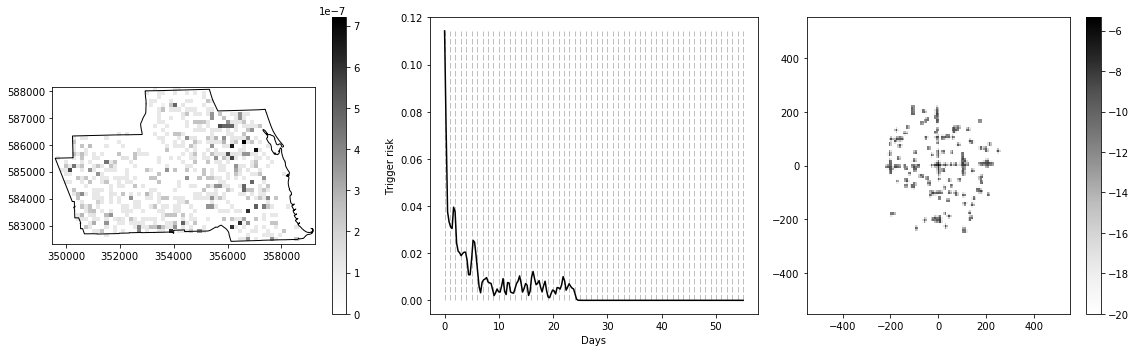

In [38]:
fig = plot(model, 550, 55, np.exp(-20))

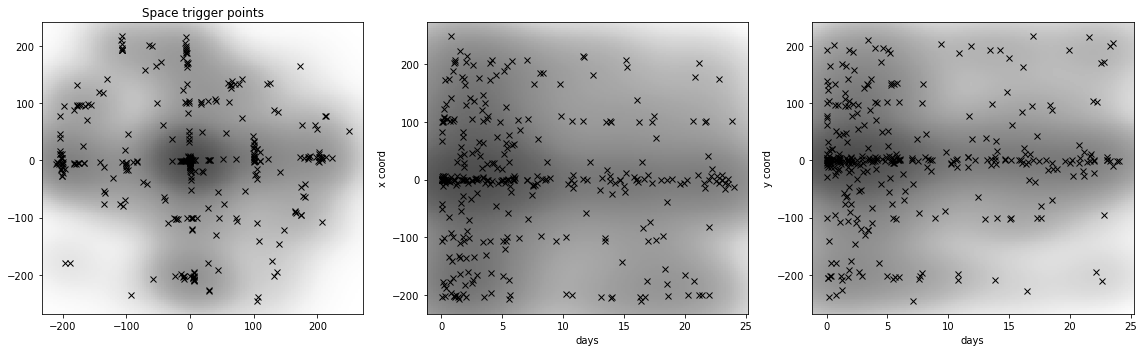

In [39]:
_ = scatter_triggers(trainer, model, datetime.datetime(2017,1,1))

**Both bandwidths slightly larger**

In [40]:
tp = sepp.kernels.FixedBandwidthKernelProvider(0.5)
sp = sepp.kernels.FixedBandwidthKernelProvider(5)
trainer = sepp.sepp_grid_space.Trainer4(grid, tp, sp)
trainer.data = points
model2 = trainer.train(datetime.datetime(2017,1,1), iterations=50)
model2

Model4(mu size=(39, 65), T=365.9583333333333, grid=RectangularRegion( (349500,582300) -> (359250,588150) ), theta=0.33779857613816144, time=<open_cp.kernels.Reflect1D object at 0x00000137A574CA20>, space=<open_cp.kernels.GaussianBase object at 0x000001379D8E7748>

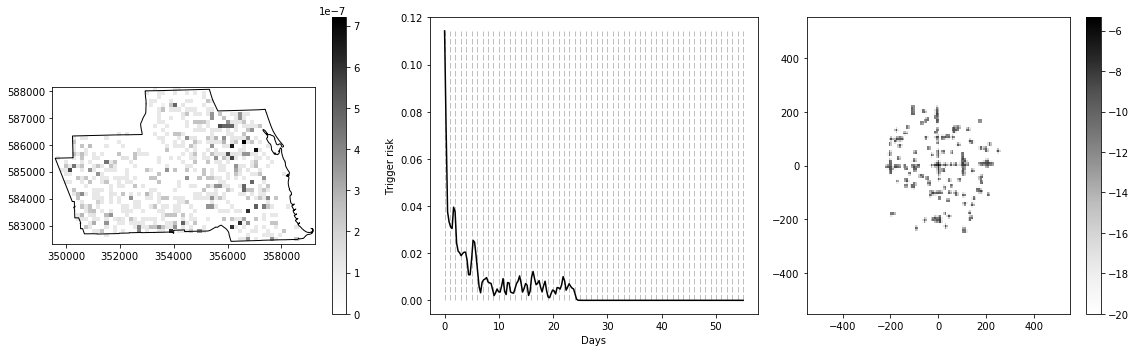

In [41]:
fig = plot(model, 550, 55, np.exp(-20))

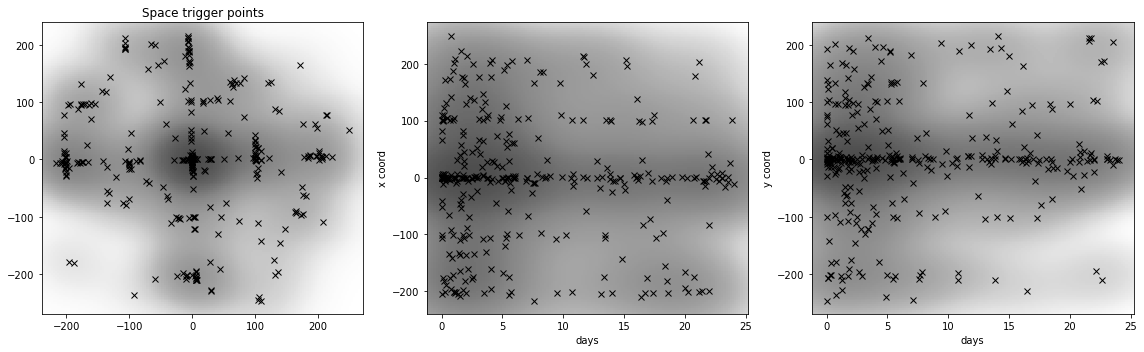

In [42]:
_ = scatter_triggers(trainer, model, datetime.datetime(2017,1,1))

## Plug-in bandwidth selection

Doesn't really work.

In [43]:
tp = sepp.kernels.PluginKernelProvider(0.2)
sp = sepp.kernels.PluginKernelProvider(1500)
trainer = sepp.sepp_grid_space.Trainer4(grid, tp, sp)
trainer.data = points
model = trainer.train(datetime.datetime(2017,1,1), iterations=50)
model

Model4(mu size=(39, 65), T=365.9583333333333, grid=RectangularRegion( (349500,582300) -> (359250,588150) ), theta=0.02990272356381195, time=<open_cp.kernels.Reflect1D object at 0x00000137A39CF128>, space=<open_cp.kernels.GaussianBase object at 0x00000137A39CFF60>

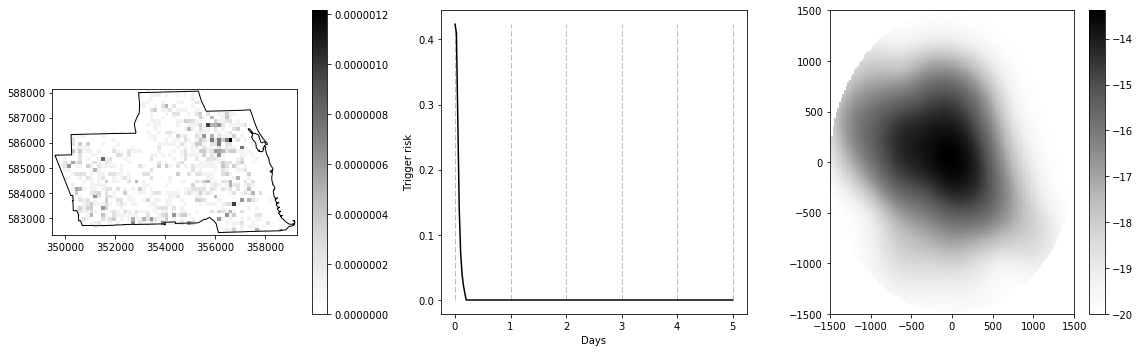

In [44]:
fig = plot(model, 1500, 5, np.exp(-20))

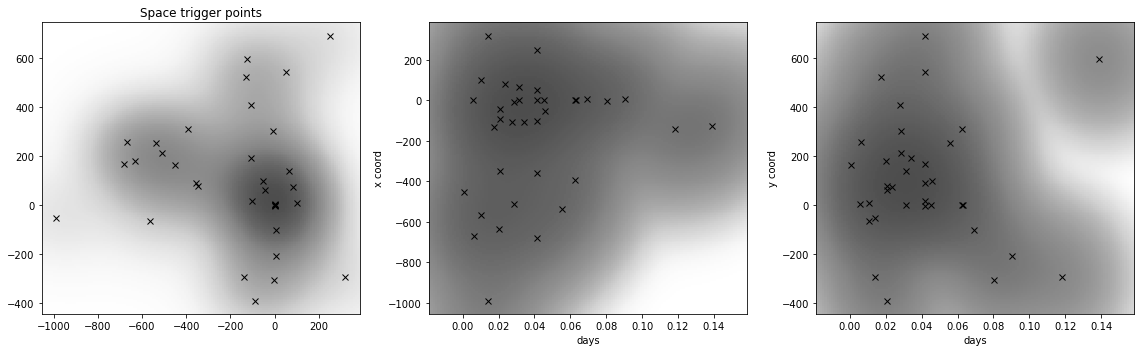

In [45]:
_ = scatter_triggers(trainer, model, datetime.datetime(2017,1,1))

## Nearest neighbour

Starts to get _very_ slow...

In [47]:
tp = sepp.kernels.FixedBandwidthKernelProvider(0.2)
sp = sepp.kernels.NearestNeighbourKernelProvider(k=15, cutoff=1500)
trainer = sepp.sepp_grid_space.Trainer4(grid, tp, sp)
trainer.data = points
model = trainer.train(datetime.datetime(2017,1,1), iterations=50)
model

Model4(mu size=(39, 65), T=365.9583333333333, grid=RectangularRegion( (349500,582300) -> (359250,588150) ), theta=0.13362045666179945, time=<open_cp.kernels.Reflect1D object at 0x00000137A3DE6C50>, space=<open_cp.kernels.GaussianNearestNeighbour object at 0x00000137A41F2208>

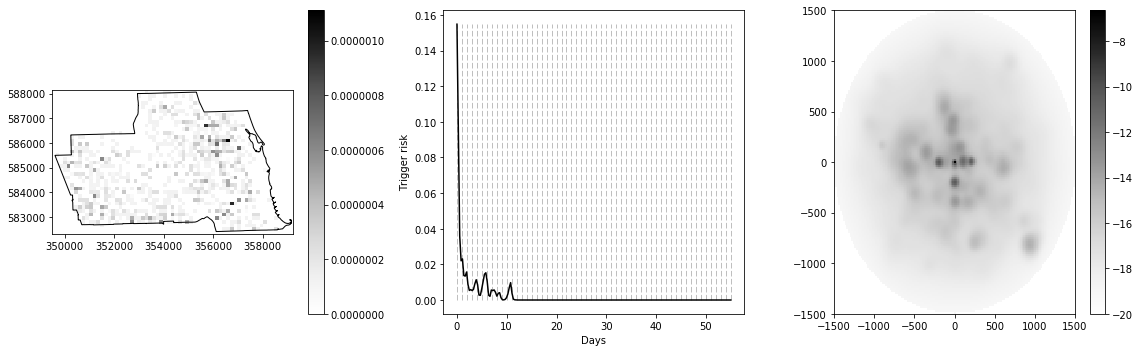

In [48]:
fig = plot(model, 1500, 55, np.exp(-20))

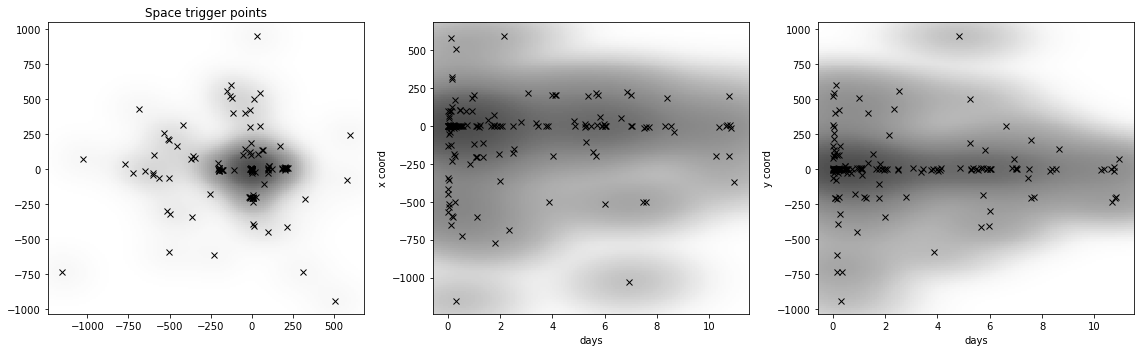

In [49]:
_ = scatter_triggers(trainer, model, datetime.datetime(2017,1,1))

In [50]:
tp = sepp.kernels.FixedBandwidthKernelProvider(1)
sp = sepp.kernels.NearestNeighbourKernelProvider(k=15, cutoff=1500)
trainer = sepp.sepp_grid_space.Trainer4(grid, tp, sp)
trainer.data = points
model1 = trainer.train(datetime.datetime(2017,1,1), iterations=50)
model1

Model4(mu size=(39, 65), T=365.9583333333333, grid=RectangularRegion( (349500,582300) -> (359250,588150) ), theta=0.37585142612079164, time=<open_cp.kernels.Reflect1D object at 0x000001379B002240>, space=<open_cp.kernels.GaussianNearestNeighbour object at 0x000001379D7B4390>

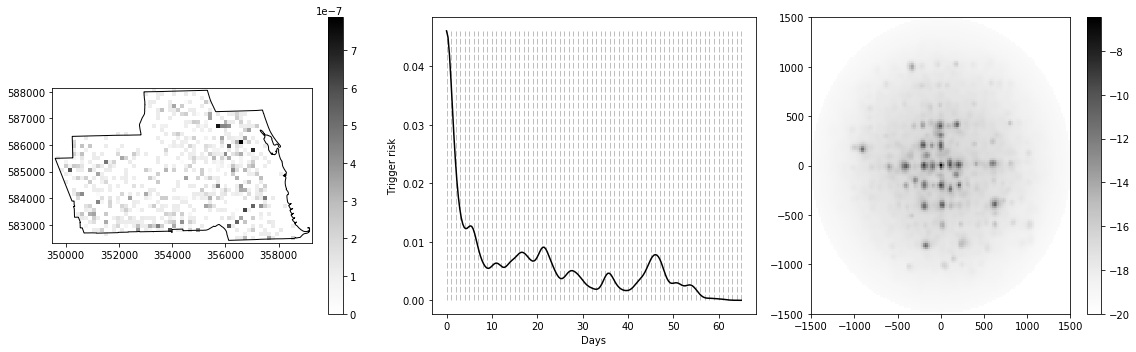

In [51]:
fig = plot(model1, 1500, 65, np.exp(-20))

In [52]:
fig.savefig("../grid_kde_knn1.pdf")

In [53]:
backgrounds, trigger_deltas = trainer.sample_to_points(model1, datetime.datetime(2017,1,1))

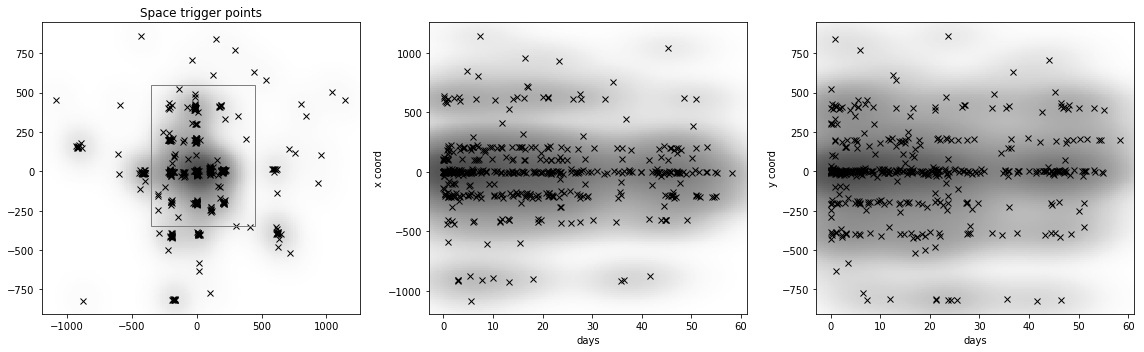

In [54]:
fig = plot_scatter_triggers(backgrounds, trigger_deltas)
ax = fig.axes[0]
r = matplotlib.patches.Rectangle((-350,-350), 800, 900, ec="grey", fc="none")
ax.add_patch(r)
None

In [55]:
fig.savefig("../grid_kde_knn2.pdf")

**Larger k value**

In [56]:
tp = sepp.kernels.FixedBandwidthKernelProvider(0.2)
sp = sepp.kernels.NearestNeighbourKernelProvider(cutoff=1000, k=30)
trainer = sepp.sepp_grid_space.Trainer4(grid, tp, sp)
trainer.data = points
model = trainer.train(datetime.datetime(2017,1,1), iterations=50)
model

Model4(mu size=(39, 65), T=365.9583333333333, grid=RectangularRegion( (349500,582300) -> (359250,588150) ), theta=0.08831665691679776, time=<open_cp.kernels.Reflect1D object at 0x00000137A09E7DD8>, space=<open_cp.kernels.GaussianNearestNeighbour object at 0x00000137A45EE5F8>

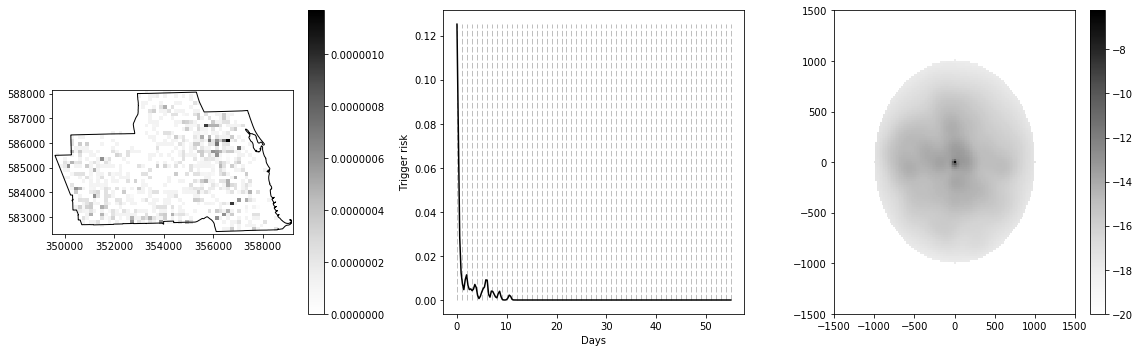

In [57]:
fig = plot(model, 1500, 55, np.exp(-20))

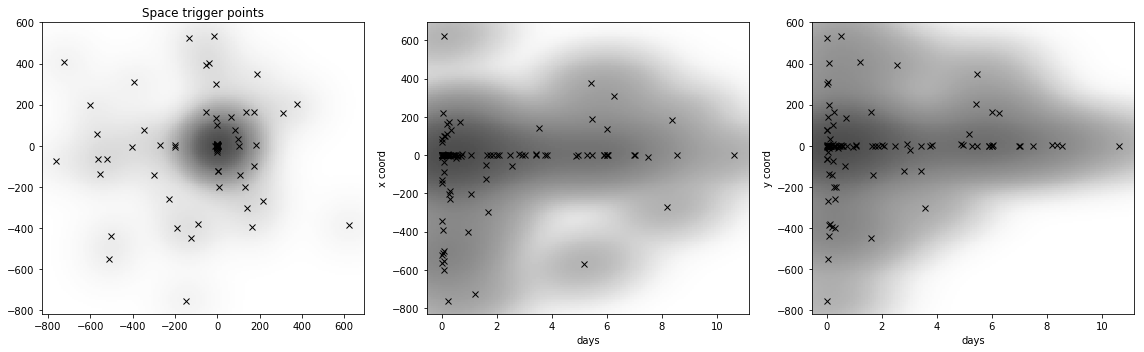

In [58]:
_ = scatter_triggers(trainer, model, datetime.datetime(2017,1,1))

**Smaller k value**

In [59]:
tp = sepp.kernels.FixedBandwidthKernelProvider(0.2)
sp = sepp.kernels.NearestNeighbourKernelProvider(3, cutoff=1000)
trainer = sepp.sepp_grid_space.Trainer4(grid, tp, sp)
trainer.data = points
model = trainer.train(datetime.datetime(2017,1,1), iterations=50)
model

Model4(mu size=(39, 65), T=365.9583333333333, grid=RectangularRegion( (349500,582300) -> (359250,588150) ), theta=0.5206460664422641, time=<open_cp.kernels.Reflect1D object at 0x000001379EE077F0>, space=<open_cp.kernels.GaussianNearestNeighbour object at 0x000001379DF376D8>

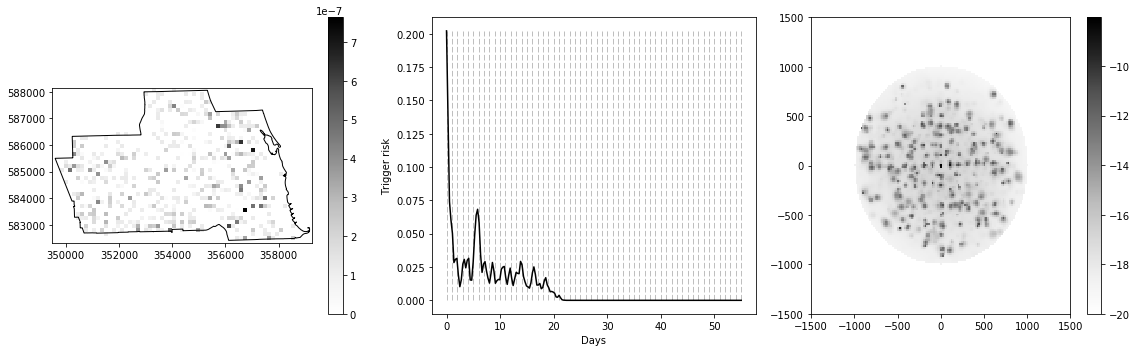

In [60]:
fig = plot(model, 1500, 55, np.exp(-20))

((3, 601), (3, 628))

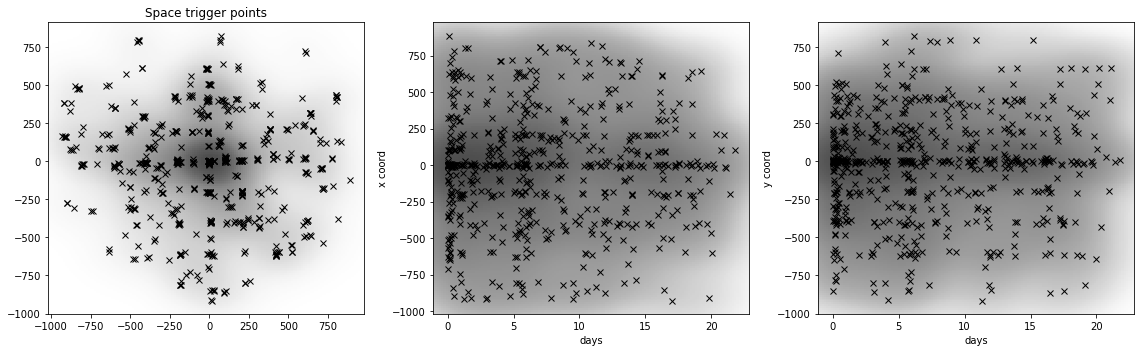

In [61]:
_, backgrounds, trigger_deltas = scatter_triggers(trainer, model, datetime.datetime(2017,1,1))
backgrounds.shape, trigger_deltas.shape

**Now with stochastic EM**

In [62]:
tp = sepp.kernels.FixedBandwidthKernelProvider(1)
sp = sepp.kernels.NearestNeighbourKernelProvider(15, cutoff=1500)
trainer = sepp.sepp_grid_space.Trainer4a(grid, tp, sp)
trainer.data = points
model = trainer.train(datetime.datetime(2017,1,1), iterations=100)
model

Model4(mu size=(39, 65), T=365.9583333333333, grid=RectangularRegion( (349500,582300) -> (359250,588150) ), theta=0.25115458236909816, time=<open_cp.kernels.Reflect1D object at 0x00000137A3DEB080>, space=<open_cp.kernels.GaussianNearestNeighbour object at 0x00000137A41E9128>

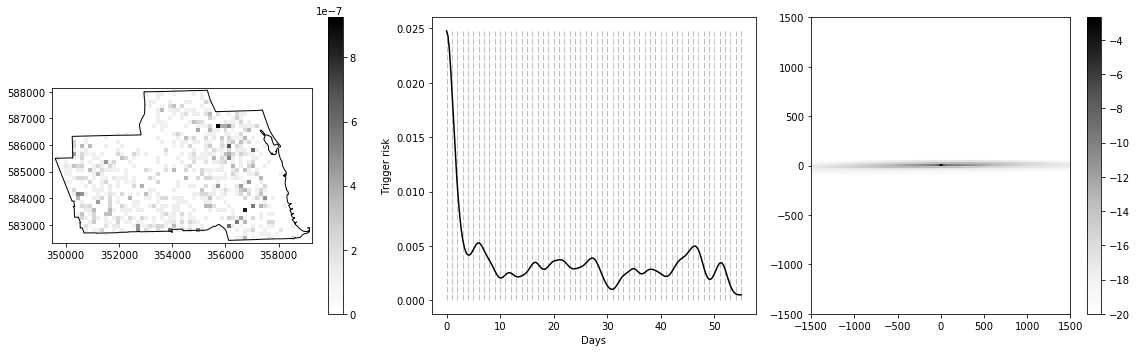

In [63]:
fig = plot(model, 1500, 55, np.exp(-20))

In [64]:
fig.savefig("../grid_kde_knn_sem_1.pdf")

((3, 929), (3, 300))

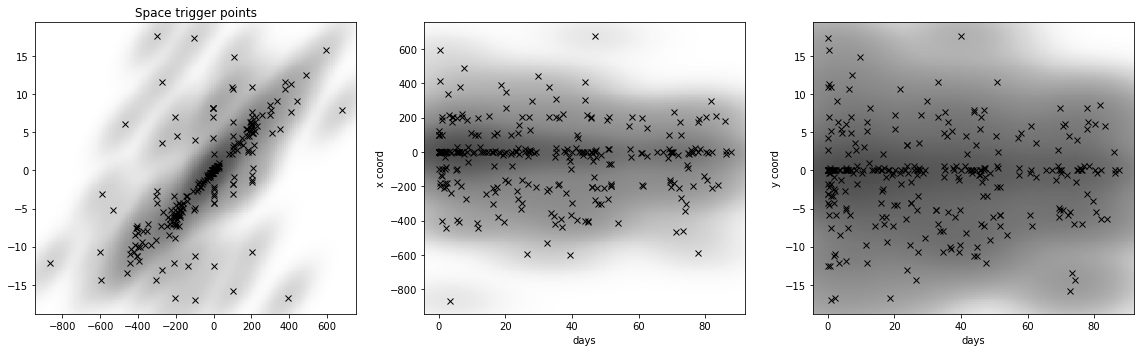

In [65]:
fig, backgrounds, trigger_deltas = scatter_triggers(trainer, model, datetime.datetime(2017,1,1))
backgrounds.shape, trigger_deltas.shape

In [66]:
fig.savefig("../grid_kde_knn_sem_2.pdf")